### 1 Loading Dataset

In [ ]:
from google.colab import drive
import sys
import os

drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/My Drive/model')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


from my_datasets import MyDataset
from my_models import MyModel
from data.model_input_all import state_on, input_0, input_4, input_5, input_6
from data.model_gt_all import label_on,label_0, label_4, label_5, label_6

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

True
cuda:0


In [ ]:
# gather all data
input_all = np.concatenate((state_on, input_0, input_4, input_5, input_6), axis = 0) 
print(input_all.shape)
label_all = np.concatenate((label_on,label_0, label_4, label_5, label_6), axis = 0)
print(label_all.shape)
data_all = np.concatenate((input_all, label_all), axis = 1) 
np.random.shuffle(data_all)
print(data_all.shape)

(30800, 8)
(30800, 2)
(30800, 10)


In [ ]:
def split_dataset(data, split_list):
    print(data.shape)
    split_num = data.shape[0] * np.array(split_list)
    print(split_num)
    return data[:round(split_num[0]), :], data[round(split_num[0]):round(split_num[1]+split_num[0]), :], data[round(split_num[1]+split_num[0]):, :]

split_list = [0.7, 0.2, 0.1]
train_input, val_input, test_input = split_dataset(data_all[:, :8], split_list)
train_label, val_label, test_label = split_dataset(data_all[:, 8:], split_list) 
print(test_input.shape)

(30800, 8)
[21560.  6160.  3080.]
(30800, 2)
[21560.  6160.  3080.]
(3080, 8)


In [ ]:
# test_dataset with only one sample for overfitting
over_input = data_all[:2, :8]
over_label = data_all[:2, 8:]

train_data = MyDataset(states = train_input, labels = train_label)
val_data = MyDataset(states = val_input, labels = val_label)
test_data = MyDataset(states = test_input, labels = test_label)
over_data = MyDataset(states = over_input, labels = over_label)   

train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=True)
over_loader = DataLoader(dataset=over_data, batch_size=2, shuffle=True)

print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Test size: %i" % len(test_data))
print("Input size: ", train_data[0][0].shape)
print("Label size: ", train_data[0][1].shape)

Train size: 21560
Validation size: 6160
Test size: 3080
Input size:  (8,)
Label size:  (2,)


In [ ]:
# Dataset & Dataloader  
data_on = np.concatenate((state_on, label_on), axis = 1) 
data_off_pos = np.concatenate((state_off_pos, label_off_pos), axis = 1) 
data_off_imp = np.concatenate((state_off_imp, label_off_imp), axis = 1)
data_all = np.concatenate((data_on, data_off_pos, data_off_imp), axis = 0)
np.random.shuffle(data_all) 
state_train = data_all[:1920, :8]
label_train = data_all[:1920, 8:]
state_val = data_all[1920:, :8]
label_val = data_all[1920:, 8:] 

train_data = MyDataset(states = state_train, labels = label_train)
val_data = MyDataset(states = state_val, labels = label_val)   

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=32, shuffle=True)

print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Input size: ", train_data[0][0].shape)
print("Label size: ", train_data[0][1].shape)

Train size: 1920
Validation size: 480
Input size:  (8,)
Label size:  (2,)


### 2 Defining Neural Network

In [ ]:
mynet = MyModel(neurons = [256,1024,2048,1024,256]) 
print(mynet)

MyModel(
  (predictor): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=1024, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=1024, out_features=2048, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=2048, out_features=1024, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=1024, out_features=256, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [ ]:
total_params = sum(p.numel() for p in mynet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in mynet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

4,734,978 total parameters.
4,734,978 trainable parameters.


### 3 Training Neural network

In [ ]:
mycriterion = nn.MSELoss() 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-3, eps = 1e-08) 

In [ ]:
def run_epoch(model,criterion,optimizer,dataloader,iftrain):    
    running_loss = 0.0  
    
    #Iterating through the minibatches of the data
    for i, data in enumerate(dataloader, 0): 
        X, y = data
        X = X.cuda()
        y = y.cuda()
        #print(i)
        if iftrain:  
            #model.train()
            optimizer.zero_grad()
            y_pred = model(X.to(torch.float32))
            #y_pred[:,1] = y_pred[:,1] * 20
            #y[:,1] = y[:,1] * 20
            y_pred = y_pred.float()
            y = y.float() 
            
            loss = criterion(y_pred, y)  
            loss.backward()             
            optimizer.step()            
            running_loss += loss.item() 
        else:
            #model.eval()
            y_pred = model(X.to(torch.float32))
            y_pred = y_pred.float()  
            y = y.float()
            #y_pred[:,1] = y_pred[:,1] * 20
            #y[:,1] = y[:,1] * 20 
            loss = criterion(y_pred , y)  
            running_loss += loss.item()    
    return running_loss    

In [ ]:
# test if the model will overfit with only one sample
max_epochs = 1000 
train_history = []
val_history = []

for epoch in range(max_epochs): 
    train_loss = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=True)
    train_history.append(train_loss)
    val_loss =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=False)
    val_history.append(val_loss)
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %2e, val_loss: %2e "% 
          (train_loss/5, val_loss/5))

Epoch  10/1000, train_loss: 1.135884e+00, val_loss: 1.132574e+00 
Epoch  20/1000, train_loss: 1.075387e+00, val_loss: 1.068882e+00 
Epoch  30/1000, train_loss: 1.006207e+00, val_loss: 9.983826e-01 
Epoch  40/1000, train_loss: 9.183260e-01, val_loss: 9.081711e-01 
Epoch  50/1000, train_loss: 8.041033e-01, val_loss: 7.908968e-01 
Epoch  60/1000, train_loss: 6.611163e-01, val_loss: 6.454957e-01 
Epoch  70/1000, train_loss: 4.983462e-01, val_loss: 4.816338e-01 
Epoch  80/1000, train_loss: 3.328844e-01, val_loss: 3.170361e-01 
Epoch  90/1000, train_loss: 1.875465e-01, val_loss: 1.753669e-01 
Epoch 100/1000, train_loss: 8.362628e-02, val_loss: 7.577865e-02 
Epoch 110/1000, train_loss: 2.557539e-02, val_loss: 2.207959e-02 
Epoch 120/1000, train_loss: 3.996962e-03, val_loss: 3.098496e-03 
Epoch 130/1000, train_loss: 2.948252e-05, val_loss: 6.421915e-06 
Epoch 140/1000, train_loss: 3.347902e-04, val_loss: 3.648285e-04 
Epoch 150/1000, train_loss: 3.784329e-04, val_loss: 3.589988e-04 
Epoch 160/

In [ ]:
# test inference 
for i, data in enumerate(over_loader, 0): 
        print(data)
        X = torch.tensor(data[0]).cuda()
        y = torch.tensor(data[1]).cuda()
        y_pred = mynet(X.to(torch.float32))
        if i < 10:
            print('test',i)
            print('prediction: {},\nground truth：{}'.format(y_pred/10, y/10)) 

[tensor([[  40.8124, -350.3716,    2.3577,    4.9372,   46.8555, -355.1320,
            2.5565,    4.9511],
        [ 116.1618, -390.7603,    2.8820,    4.9361,  123.6686, -393.0976,
            2.8389,    4.9405]], dtype=torch.float64), tensor([[ 3.3262, -0.5764],
        [ 3.4530, -0.4223]], dtype=torch.float64)]
test 0
prediction: tensor([[ 0.3326, -0.0576],
        [ 0.3453, -0.0422]], device='cuda:0', grad_fn=<DivBackward0>),
ground truth：tensor([[ 0.3326, -0.0576],
        [ 0.3453, -0.0422]], device='cuda:0', dtype=torch.float64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


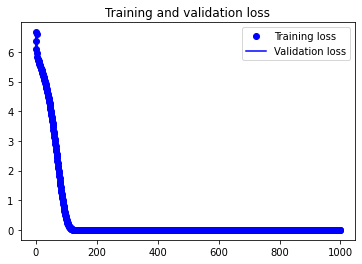

In [ ]:
# plot the train&validation loss curve with only one sample
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [ ]:
mycriterion = nn.MSELoss() 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-6, eps = 1e-08) 

In [ ]:
# start the main training process
max_epochs = 1000
num_trainbatch = np.ceil(len(train_data)/256) 
num_valbatch = np.ceil(len(val_data)/256) 
train_history = []
val_history = []

min_loss = 100000
current_patience = 0
patience = 5

print('Start training!')

for epoch in range(max_epochs): 
    train_loss = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=train_loader,
                           iftrain=True)
    train_history.append(train_loss/num_trainbatch)
    val_loss =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=val_loader,
                           iftrain=False)
    val_history.append(val_loss/num_valbatch)
    if epoch % 5 == 4:
      print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %e, val_loss: %e "% 
          (train_loss/num_trainbatch, val_loss/num_valbatch))
'''
    # early stopping
    if min_loss == 100000 or val_loss < min_loss :
        min_loss = val_loss
        current_patience = 0
        torch.save(mynet.state_dict(),'mynet.pth')
      
    else :
        current_patience += 1 
        if current_patience >= patience :
            print("Stopping early at epoch {}!".format(epoch+1)) 
            break   '''

print('FINISH.')

Start training!
Epoch  20/1000, train_loss: 1.079891e-02, val_loss: 8.906062e-01 
Epoch  40/1000, train_loss: 1.062449e-02, val_loss: 9.012913e-01 
Epoch  60/1000, train_loss: 1.060107e-02, val_loss: 8.989973e-01 
Epoch  80/1000, train_loss: 1.058286e-02, val_loss: 1.401428e+00 
Epoch 100/1000, train_loss: 1.072698e-02, val_loss: 1.272632e+00 
Epoch 120/1000, train_loss: 1.071967e-02, val_loss: 8.905805e-01 
Epoch 140/1000, train_loss: 1.054741e-02, val_loss: 8.944566e-01 
Epoch 160/1000, train_loss: 1.175690e-02, val_loss: 8.957731e-01 
Epoch 180/1000, train_loss: 1.066370e-02, val_loss: 8.949979e-01 
Epoch 200/1000, train_loss: 1.055082e-02, val_loss: 1.002204e+00 
Epoch 220/1000, train_loss: 1.052482e-02, val_loss: 1.365541e+00 
Epoch 240/1000, train_loss: 1.053645e-02, val_loss: 9.454292e-01 
Epoch 260/1000, train_loss: 1.050890e-02, val_loss: 9.277796e-01 
Epoch 280/1000, train_loss: 1.051211e-02, val_loss: 8.893557e-01 
Epoch 300/1000, train_loss: 1.059171e-02, val_loss: 8.927988

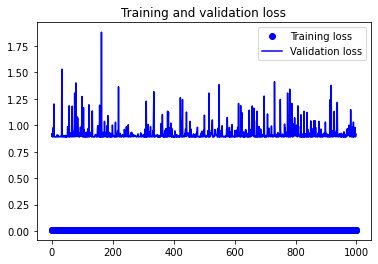

In [ ]:
# plot the train&validation loss curve 
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()


In [ ]:
# save trained model
torch.save(mynet.state_dict(),'/content/drive/My Drive/model/mynet5.pth')

In [ ]:
mynet.load_state_dict(torch.load('mynet.pth'))

NameError: name 'mynet' is not defined

In [ ]:
# test inference 
for n, data in enumerate(test_loader): 
        X = torch.tensor(data[0]).cuda() 
        y = torch.tensor(data[1]).cuda()
        if n < 2:
          for i, x in enumerate(X): 
            mynet.eval()
            x = x[None, :]
            y_pred = mynet(x.to(torch.float32)) 
            if i < 10:
              print('test',i)
              print('prediction  : {},\nground truth：{}'.format(y_pred/10, y[i]/10)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


test 0
prediction  : tensor([[ 1.0092, -0.0248]], device='cuda:0', grad_fn=<DivBackward0>),
ground truth：tensor([ 1.0000, -0.0322], device='cuda:0', dtype=torch.float64)
test 1
prediction  : tensor([[-0.0025,  0.0130]], device='cuda:0', grad_fn=<DivBackward0>),
ground truth：tensor([7.2873e-06, 1.7497e-02], device='cuda:0', dtype=torch.float64)
test 2
prediction  : tensor([[ 0.9739, -0.0021]], device='cuda:0', grad_fn=<DivBackward0>),
ground truth：tensor([ 1.0000, -0.0269], device='cuda:0', dtype=torch.float64)
test 3
prediction  : tensor([[ 0.0164, -0.7259]], device='cuda:0', grad_fn=<DivBackward0>),
ground truth：tensor([ 0.0000, -0.6348], device='cuda:0', dtype=torch.float64)
test 4
prediction  : tensor([[0.9283, 0.9805]], device='cuda:0', grad_fn=<DivBackward0>),
ground truth：tensor([1.0000, 1.0000], device='cuda:0', dtype=torch.float64)
test 5
prediction  : tensor([[ 0.4242, -0.0259]], device='cuda:0', grad_fn=<DivBackward0>),
ground truth：tensor([ 0.4331, -0.0222], device='cuda:0',